# Comunicados de Política Monetaria
## Parte 1.

En este notebook crearemos un pandas DataFrame con las decisiones de política monetaria de Banxico y haremos un análisis de la información recabada.

In [1]:
import re
import os
from os import listdir
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
from tqdm.notebook import tqdm
import numpy as np
import requests
from nltk import corpus
import nltk
nltk.download("stopwords")
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmartinezdelarosa/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

La información de decisción de política monetaria se encuentra en la siguiente url.

In [3]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

* Entra a `url` y analiza la página.

In [4]:
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


* Como podemos observar, la url objetivo contiene
    * las fechas de decisiones de política monetaria,
    * el resumen de las decisiones de política monetaria y
    * una url que nos dirige a un pdf con el texto completo del Anuncio de Política Monetaria.
    
<h3 style="color:crimson">Ejercicio</h3>

1. Por medio de `requests_html`, extrae los tres puntos antes mencionados y guárdalos dentro de un DataFrame con columnas `"date"`, `"text"` y `"url"`;
2. Con el dataframe seleccionado, filtra todos comunicados anteriores al 15 de febrero de 2008, i.e., queremos todos los comunicados a partir del 15 de Febrero de 2008;
3. Guarda tu DataFrame dentro de un archivo `.pkl` con nombre `comunicados-banxico.pkl`: **hint:** Revisa el uso del método `to_pickle`.

In [5]:
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [6]:
len(r.html.find("tr"))

184

In [7]:
tr = r.html.find("table[class='table table-striped bmtableview']", first=True)

In [8]:
all_tr = tr.find("tr")

In [9]:
all_tr[0].text

'13/02/20\nEl objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) disminuye en 25 puntos base\nTexto completo'

In [10]:
len(all_tr)

184

In [11]:
import locale
locale.setlocale(locale.LC_TIME, "es_ES.UTF-8")

'es_ES.UTF-8'

In [12]:
def extract_info(tr):
    class_date = "td[class='bmdateview']"
    class_text = "td[class='bmtextview']"
    
    url_tr, *_ = tr.find(class_text, first=True).absolute_links
    texto = tr.find(class_text, first=True).text
    date_str = tr.find(class_date, first=True).text
    date = datetime.strptime(date_str, "%d/%m/%y")
    
    return {
        "date": date,
        "text": texto,
        "url": url_tr
    }

In [13]:
len(extract_info(tr))

3

In [14]:
content = [extract_info(tr) for tr in all_tr]
content = pd.DataFrame(content)
content = content.set_index('date')
content1 = content[:"2008-02-15"]
content1.sort_index(ascending=True).head()

,text,url
date,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


<h3 style="color:crimson">Ejercicio</h3>

Por medio del método `str.extract` para un pandas Series, crea una nueva columna `"category"` que extraiga del texto si la tasa se 
1. `"mantiene"`
2. `"incrementa"`
3. `"disminuye"`

In [15]:
content1['category'] = content1.text.str.extract('(mantiene|incrementa|disminuye)')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
content1.sort_index(ascending=True).head()

,text,url,category
date,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa


<h3 style="color:crimson">Ejercicio</h3>

Cuenta las veces en las que la tasa se mantuvo, se incrementó o se disminuyó.

In [17]:
frecuencias = (pd.Series(content1['category'].values.ravel()).value_counts())
frecuencias

mantiene      72
incrementa    18
disminuye     16
dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Reproduce la siguiente figura sobre los comunicados de prensa de Banxico:
1. La gráfica de la izquierda representa una serie de tiempo sobre los comunicados de banxico. Si `y=1`, la tasa de referencia se incrementó; si `y=0`, la tasa se mantuvo; finalmente, si `y=-1`, la tasa disminuyó.
2. La gráfica de la derecha es una gráfica de barras del ejercicio anterior

In [18]:
feliz =pd.DataFrame(content1, columns = ['category'])
for i in range(len(feliz['category'])):
    if feliz['category'][i] == 'disminuye':
        feliz['category'][i] = -1
    if feliz['category'][i] == 'mantiene':
        feliz['category'][i] = 0
    elif feliz['category'][i] == 'incrementa':
        feliz['category'][i] = 1
feliz

,category
date,
2020-02-13,-1
2019-12-19,-1
2019-11-14,-1
2019-09-26,-1
2019-08-15,-1
...,...
2008-06-20,1
2008-05-16,0
2008-04-18,0


Text(0.5, 1.0, 'Frecuencia de categorías')

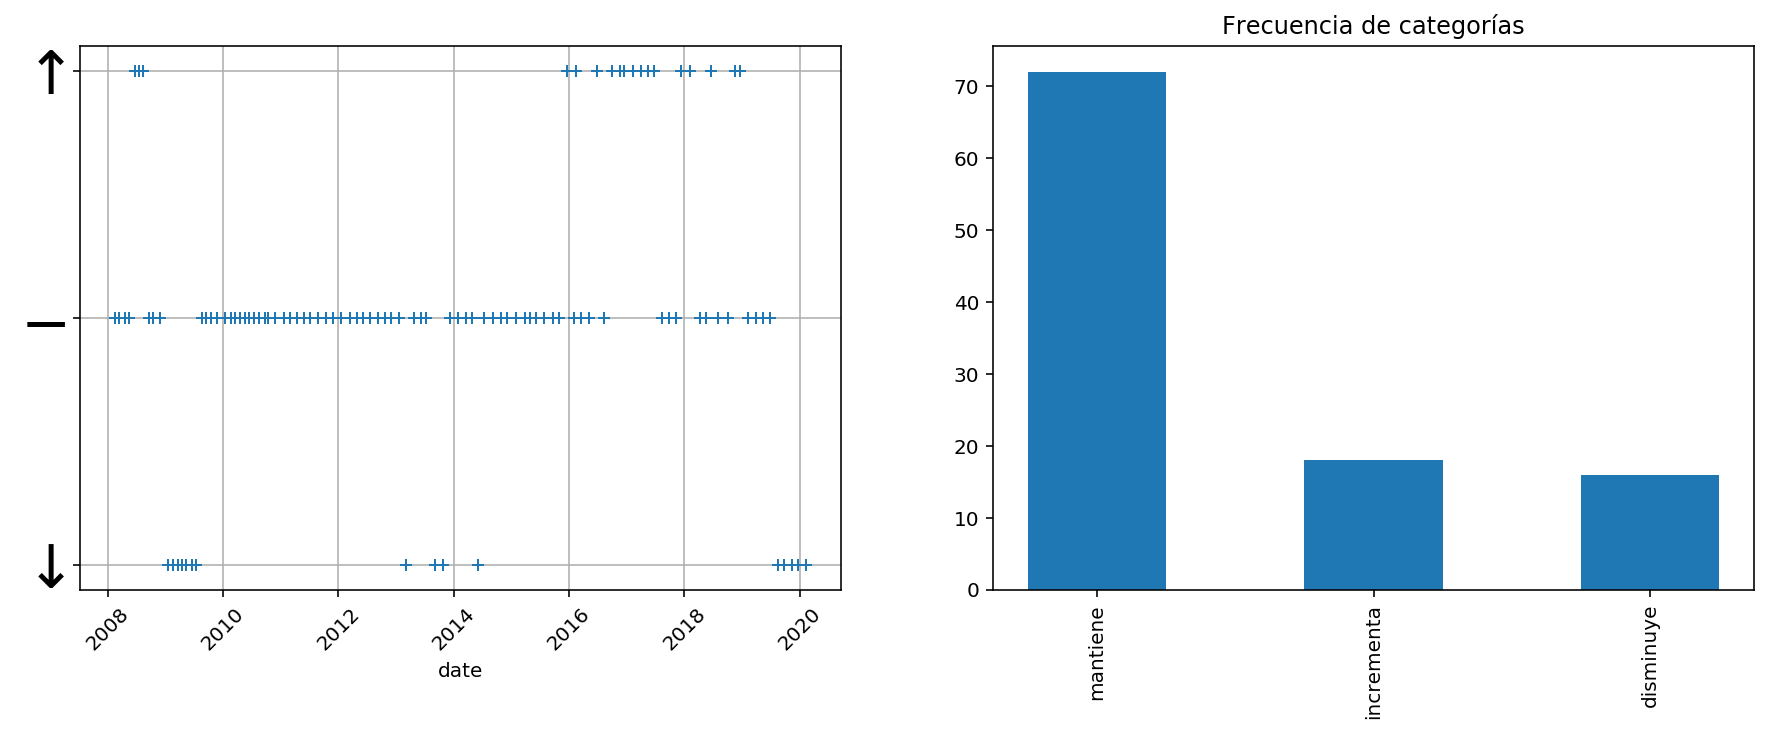

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

plt.subplot2grid((1,2),(0,0))
plt.yticks([-1, 0, 1],[r'$\downarrow$', r'$ - $', r'$\uparrow$'], fontsize=30)
plt.plot(feliz,linestyle = "", marker = '+')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.grid(True)

plt.subplot2grid((1,2),(0,1))
plt.xticks(rotation=90)
plt.bar(['mantiene', 'incrementa', 'disminuye'], feliz["category"].value_counts(), width=0.50)
plt.title('Frecuencia de categorías')

<h3 style="color:crimson">Ejercicio</h3>

Agrupa por año y cuenta el número de comunicados en un año para cada categoría.

In [20]:
feliz1 =pd.DataFrame(content1, columns = ['category'])
content1['años']= pd.to_datetime(content1.index.values).strftime("%Y")
A = (content1.groupby(['años', 'category']).agg('category')).count()
A.head(5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


años  category  
2008  incrementa     3
      mantiene       7
2009  disminuye      7
      mantiene       4
2010  mantiene      11
Name: category, dtype: int64

<h3 style="color:crimson">Ejercicio</h3>

Con el resultado anterior, replica la siguiente gráfica

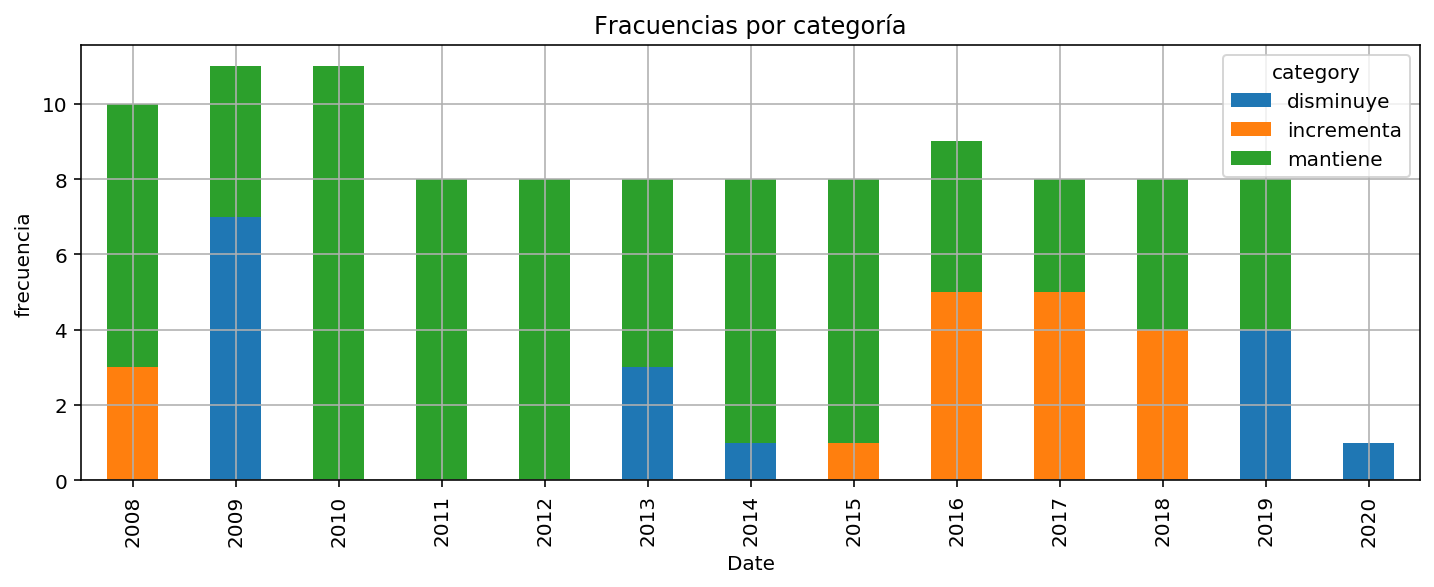

In [21]:
A.unstack().plot(kind = 'bar', stacked = True)
plt.title('Fracuencias por categoría')
plt.xlabel('Date')
plt.ylabel('frecuencia')
plt.grid(True)

## Parte 2.

* Ocupando **únicamente** pandas, numpy; matplotlib; seaborn, con la información obtenida en la parte 1 (pandas DataFrame) modelar con Naïve Bayes si un documento dado pertence a la clase `mantiene`, `sube`, `baja`

## Pasos
1. Descargar PDFs
2. Limpiar los datos
3. Eliminar de todos los archivo las palabras que contengan `mantiene`, `sube`, `baja`.
4. Parte los documentos entre un set de entrenamiento (0.8) y uno de prueba (0.2)
5. Entrena el modelo con los documentos de entrenamiento y valida el resultado con una matriz de confusión usado la base de prueba

In [22]:
if not os.path.exists("descargas"):
    os.mkdir("descargas")

In [23]:
def url_response(url):
    path_full=os.path.join("descargas", "path", "url")
    path, url = url

    r = requests.get(url, stream = True)
    
    with open(path, 'wb') as f:

        for ch in r:

            f.write(ch)

In [24]:
urls = []
for i in range(len(content1['url'])):
    url = (content1.index[i].strftime("%d-%B-%Y")+".pdf", content1['url'][i])
    urls.append(url)

In [25]:
from time import time
start = time()

for x in urls:

    url_response (x)

print(f"Time to download: {time() - start}")

Time to download: 41.92661094665527


In [26]:
!pip install PyPDF2

In [28]:
from PyPDF2 import PdfFileReader
texto=defaultdict(list)
for i in range(len(content1['category'])):
    path = content1.index[i].strftime("%d-%B-%Y")+".pdf"
    with open(path, 'rb') as f:
        pdf = PdfFileReader(f)
        page = pdf.getPage(0)
        text = page.extractText().lower()
        texto[content1['category'][i]].append(text)
        #print(text)
    

## Limpieza de datos

In [29]:
k1, k2, k3 = 'mantiene', 'incrementa', 'disminuye'

In [94]:
def limpia_texto(doc):
    limpio = doc.lower()
    limpio = re.sub("[^\w ]", "", limpio)
    quita = re.sub("mantiene|incrementa|disminuye", "", limpio)
    return limpio

In [95]:
D1 = [limpia_texto(doc) for doc in texto[k1]]
D2 = [limpia_texto(doc) for doc in texto[k2]]
D3 = [limpia_texto(doc) for doc in texto[k3]]

D1, D1_test = train_test_split(D1, test_size=0.2)
D2, D2_test = train_test_split(D2, test_size=0.2)
D3, D3_test = train_test_split(D3, test_size=0.2)

## Analizando los datos

In [96]:
N1 = len(D1)
N2 = len(D2)
N3 = len(D3)
###con lo siguiente solo se desea ver el tamaño total para verificar
n1 = len(D1_test)
n2 = len(D2_test)
n3 = len(D3_test)
M= N1 + N2 + N3 + n1+ n2+ n3
##### Valor de N
N = N1 + N2 + N3
N

83

In [97]:
!pip install stopwords

In [98]:
stopwords = corpus.stopwords.words("spanish")
stopwords = [unidecode(word) for word in stopwords]

In [99]:
V1 = []
for dialogo in D1:
    for palabra in dialogo.split():
        if palabra not in stopwords:
            V1.append(palabra)

In [100]:
V2 = []
for dialogo in D2:
    for palabra in dialogo.split():
        if palabra not in stopwords:
            V2.append(palabra)

In [101]:
V3 = []
for dialogo in D3:
    for palabra in dialogo.split():
        if palabra not in stopwords:
            V3.append(palabra)

In [102]:
mantiene = len(set(V1)) / len(V1)
incrementa = len(set(V2)) / len(V2)
disminuye = len(set(V3)) / len(V3)
print('mantiene''=', mantiene, 'incrementa''=', incrementa, 'disminuye''=',disminuye)

mantiene= 0.12665558167536264 incrementa= 0.2778836987607245 disminuye= 0.2763731473408893


In [103]:
pd.Series(V1).value_counts()

inflación        324
crecimiento      188
precios          171
economía         169
monetaria        164
                ... 
repuntar           1
exhibió            1
recibidas          1
ocasionar          1
contrarrestan      1
Length: 2209, dtype: int64

In [104]:
pd.Series(V2).value_counts()

monetaria        55
política         50
inflación        49
economía         48
méxico           43
                 ..
derivan           1
buena             1
sujeta            1
precisamente      1
mantenimiento     1
Length: 1166, dtype: int64

In [105]:
pd.Series(V3).value_counts()

inflación     54
económica     41
actividad     39
riesgos       39
méxico        38
              ..
ordenadas      1
demandas       1
ancladas       1
permiten       1
principios     1
Length: 951, dtype: int64

In [106]:
V = set(V1) | set(V2) | set(V3)
vocab = pd.DataFrame(index=V)

In [107]:
V1_c = pd.Series(V1, name="k1").value_counts()
V2_c = pd.Series(V2, name="k2").value_counts()
V3_c = pd.Series(V3, name="k3").value_counts()

In [108]:
L = (vocab.join(V1_c, how = "left")
          .join(V2_c, how = "left")
          .join (V3_c, how = "left"))

L = L.fillna(0) + 1
L = L / L.sum(axis=0)
L.sample(10, random_state=314)

,k1,k2,k3
confianza,0.000699,0.000589,0.000993
genéricos,0.000200,0.000147,0.000166
detalle,0.000050,0.000294,0.000331
mostrar,0.000249,0.000147,0.000331
375,0.000150,0.000441,0.000331
27,0.000200,0.000147,0.000166
hipotecario,0.000100,0.000147,0.000166
rompieron,0.000100,0.000147,0.000166
tarifas,0.000549,0.000147,0.000331
competencia,0.000150,0.000147,0.000166


In [126]:
log_prior_k1 = np.log(N1 / N)
log_prior_k2 = np.log(N2 / N)
log_prior_k3 = np.log(N3 / N)
log_priors = np.array([log_prior_k1, log_prior_k2, log_prior_k3])

In [127]:
D_test = D1_test + D2_test + D3_test
y_test = ["k1"] * len(D1_test) + ["k2"] * len(D2_test) + ["k3"] * len(D3_test)
y_test

['k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k2',
 'k2',
 'k2',
 'k2',
 'k3',
 'k3',
 'k3',
 'k3']

In [131]:
log_L=np.log(L)
yhat_test = []

for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    yhat_test.append(res.idxmax())

In [132]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_test)

array([[11,  4,  0],
       [ 1,  3,  0],
       [ 4,  0,  0]])